In [ ]:
!pip install einops
!pip install torchinfo
!pip install datasets

# HW8: Diffusions & Low-Rank Adaptation (LoRA)

In this assignment, you will learn to implement diffusion model and low-rank adaptation (LoRA) from scratch using the Pytorch library.

This homework consists of two main sections:


In the first section, we introduce the diffusion model where you will be tasked to implement various components for training diffusion model, including a noise scheduler, sampling module, and model architectures. After building our these compoments, we will assemble them and train the diffusion model on the MNIST dataset.

The second part will introduce you to parameter-efficient transfer learning (PET) where LoRA will be used to transfer the MaskFormer (https://arxiv.org/abs/2107.06278), an instance segmentation model, to semantic segmentation task on a satellite-building segmentation dataset. This section will teach you how LoRA works and how to implement it from scratch using ```forward_hook```.

# Part 1: Diffusion Model

In this section, you will be tasked to implement each component of the diffusion model (DDPM).

Based on the components in DDPM, this section is organized into four parts :

1. **Noise Scheduler (Foward Process)**: During diffusion's forward process, the noise was gradually added, transforming the clean image $x_0$ into noisy image $x_t$ w.r.t to the timestep $t$. To do so, the noise scheduler is used for controlling the amount of noise to be added in each timestep.

2. **Sampling (Reverse Process)**:  During the revesere process, the sampling algorithm is employed to update $x_t$ to remove the noise inside it using the noise estimation model $\theta$.

3. **Model Architecture**: The deep learning model $\theta$ is for predicting the noise in $x_t$ to be used in reverse process. In this homework, we will use UNet as a base architecture.

4. **Training Process**: The training process will combine these three modules to perform a learning process.

The overview of the system is shown below.



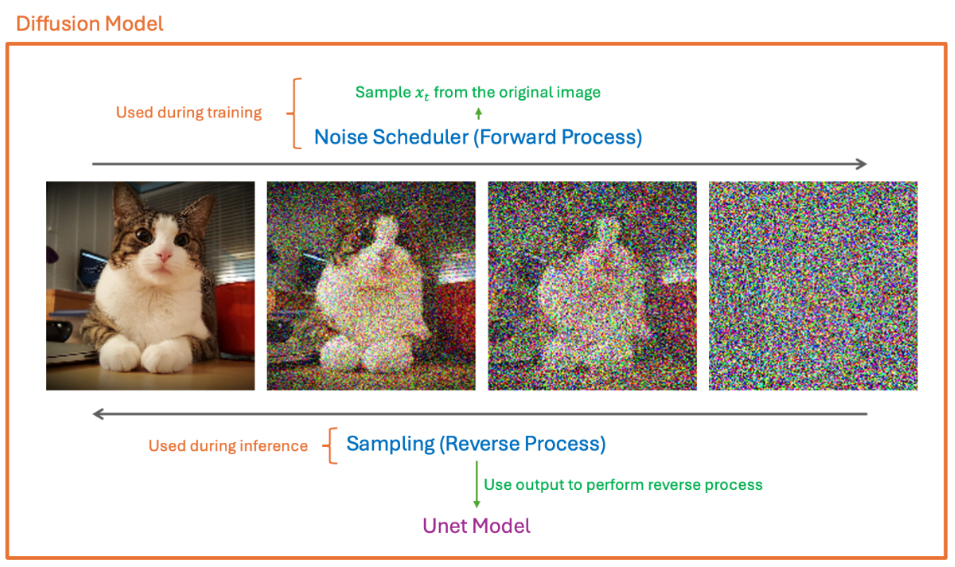

## Downloading CIFAR10 Dataset

The MNIST dataset comprises of 60,000 training images at 32x32 resolution; the images are normalized to [-1, 1]. In the following, you will learn how to train diffusion on this dataset.

In [ ]:
import os
import torch
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Resize
from einops import rearrange
from tqdm import tqdm
# from torch_ema import ExponentialMovingAverage

class Rescale(object):
    def __init__(self, old_range, new_range):
        self.old_range = old_range
        self.new_range = new_range

    def __call__(self, image):
        old_min, old_max = self.old_range
        new_min, new_max = self.new_range
        image -= old_min
        image *= (new_max - new_min) / (old_max - old_min)
        image += new_min
        return image

normalize_to_neg_one_to_one = Rescale((0, 1), (-1, 1))
unnormalize_to_zero_to_one = Rescale((-1, 1), (0, 1))

RESOLUTION = (32, 32)
BATCH_SIZE = 64

transform = Compose([
    Resize(RESOLUTION), lambda x: x.convert('RGB'), ToTensor(), normalize_to_neg_one_to_one
])

training_data = datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_data = datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_dataloader = DataLoader(training_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

These are example images from the CIFAR dataset.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(ncols=9, figsize=(15, 75))
for i in range(9):
  image, label = training_data[i]
  axs[i].imshow(rearrange(unnormalize_to_zero_to_one(image), "c h w -> h w c"))
  axs[i].set_title(training_data.classes[label])
  axs[i].set_axis_off()
plt.show()

## Noise Scheduler

The noise scheduler controls the acceleration of the noise added through the forward process, transfroming the clean image $x_0$ into noisy image $x_t$ w.r.t. the timestep $t$. Typically, the noise scheduler is categorized into two classes: Variance Preserving and Variance Exploding. However, for this homework, we focus on the variance-preserving scheduler ($\alpha_t = 1 - \beta_t$). You task is to implement linear and cosine schedulers based on the description provided below.

The noise scheduler consists of four parameters:
1. alpha ($\alpha$): A numpy array that stores $\alpha_t$ (`alpha[i] =` $\alpha_i$).
2. alpha_cumprod ($\bar{\alpha}$): A numpy array that stores cumulative product of $\alpha$ (`alpha_cumprod[i] =` $\bar{\alpha}_i$; $\quad$ $\bar{\alpha}_t = \prod_{i=0}^t \alpha_i$)
3. alpha_cumprod_prev: The shifted version of alpha_cumprod such that `alpha_cumprod_prev[i] =` $\bar{\alpha}_{i-1}$ and `alpha_cumprod_prev[0] = 1`.
4. beta ($\beta$): A numpy array stores $\beta_t$ (`beta[i] =` $\beta_i$).

After initializing the parameters, we are going to sample $x_t \sim p(x_t |x_0, t)$ where $p(x_t| x_0, t)$ is a normal distribution with the mean and variance defined as $\sqrt{\bar{\alpha}_t}x_0$ and $(1-\bar{\alpha}_t) \mathbf{I}$, respectively ($p(x_t |x_0, t) = \mathcal{N}(\sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t) \mathbf{I})$). When sampling from a normal distribution, it can be done using the following equation (reparameterization trick):
\begin{aligned}
x &\sim \mathcal{N}(x; \mu, \sigma^2) \\
x &= \mu + \sigma z \quad z \sim \mathcal{N} (0, \mathbf{I}) \\
\end{aligned}

**Instruction**

TODO 1: initialize parameters in the scheduler for the linear scheduler. ($\beta$ is linearly space between 0.0001 and 0.02.) \
TODO 2: initialize parameters in the scheduler for the cosine scheduler. \
TODO 3: calculate mean of $p(x_t | x_0, t)$ $=>\sqrt{\bar{\alpha}_t} x_0$  \
TODO 4: calculate std of $p(x_t |x_0, t)$ $=> \sqrt{1 - \bar{\alpha}_t}$\
TODO 5: sample $x_t \sim p(x_t | x_0, t)$ using a reparameterization trick in VAE

**Hint**: You can use `torch.cumprod` to calculate cumulative product.


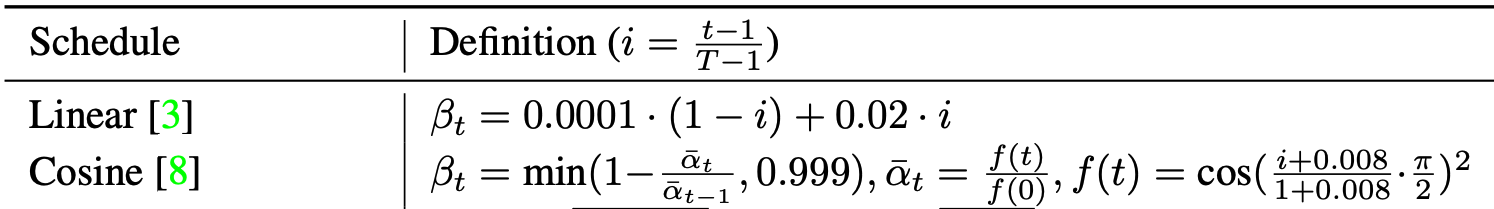

In [ ]:
import torch
import torch.nn.functional as F
import numpy as np

def expand_axis_like(a, b):
    """ Expands axes (at the end) of b to have the same number of axis as a.

    Args:
        a (Tensor): A reference tensor.
        b (Tensor): A target tensor to be expanded.

    Returns:
        Expanded version of b.

    """
    assert len(a.shape) >= len(b.shape), f"The number of axis in a must greater than b. Shape a: {a.shape}, Shape b: {b.shape}"
    n_unsqueeze = len(a.shape) - len(b.shape)
    b = b[(..., ) + (None, ) * n_unsqueeze] # unsqueeze such that it has the same size for broadcasting.
    return b

class NoiseScheduler:
    def __init__(self, T, mode="linear"):
        """ Noise Scheduler Abstract Class

        Args:
            T (int): A maximum number of diffusion timestep.

        """
        self.T = T
        self.mode = mode
        self.init_alpha_beta()

    def init_alpha_beta(self):
        """ Initialize alpha and beta parameters based on the scheduler. """
        if self.mode == "linear":
            # TODO 1: initialize parameters for linear scheduler
            self.beta = None
            self.alpha = None
            self.alpha_cumprod = None
            self.alpha_cumprod_prev = None
        elif self.mode == "cosine":
            # TODO 2: initialize parameters for cosine scheduler
            self.alpha_cumprod = None
            self.alpha = None
            self.beta = None
            self.alpha_cumprod_prev = None
        else:
            raise NotImplementedError

    def _mean(self, x_0, t):
        """ Mean of p(x_t | x_0, t)

        Args:
            x_0 (Tensor): Clean images (Shape: (B, C, H, W))
            t (Tensor): Diffusion time-step (Shape: (B))

        Returns:
            Mean of p(x_t | x_0, t) (Shape: (B, C, H, W))

        """
        # TODO 3: calculate mean of p(x_t | x_0, t)
        x_mean = None
        return x_mean

    def _std(self, t):
        """ Standard deviation of p(x_t | x_0, t)

        Args:
            t (Tensor): Diffusion time-step (Shape: (B))

        Returns:
            Standard deviation of p(x_t | x_0, t) (Shape: (B))

        """
        # TODO 4: calculate standard deviation of p(x_t| x_0, t)
        std = None
        return std

    def marginal_prob(self, x_0, t):
        """ Marginal probability p(x_t | x_0, t)"""
        return self._mean(x_0, t), self._std(t)

    def sample_marginal_prob(self, x_0, t, noise=None):
        """ Sample x_t from p(x_t | x_0, t)

        Args:
            x_0 (Tensor): Clean images (Shape: (B, C, H, W))
            t (Tensor): Diffusion time-step (Shape: (B))
            noise (Tensor): A gaussian noise to be used in the reparameterization trick.
                            If it is None, noise is sample from standard normal. Default to None
        Returns:
            x_t (Shape: (B, C, H, W))

        """
        # TODO 5: sample $x_t \sim p(x_t | x_0, t)$ using a reparameterization trick in VAE
        # Note: You can use marginal_prob function to obtain the mean and std of p(x_t| x_0, t).
        #       If noise is provided, you must use it to sample x_t by setting z = noise. Otherwise, z is sampled from standard normal.
        mean, std = self.marginal_prob(
            x_0, t
        )  # Compute mean and std of the marginal prob.

        x_t = None
        return x_t

    def prior_sampling(self, resolution, batch_size=1, num_channels=3):
        """ Sampling Gaussian noise

        Args:
            resolution (Tuple[int]): A tuple of integer indicates width and height of the image.
            batch_size (int, optional): A number of noise to be generated.
            num_channels (int, optional): A number of channels in the images.

        Returns:
            The sampling noises sample from Gaussian distribution.

        """
        return torch.randn(batch_size, num_channels, *resolution)

    def to(self, *args, **kwargs):
        """ Store the parameters on the given devices (eg. cpu, cuda) """
        self.alpha = self.alpha.to(*args, **kwargs)
        self.beta = self.beta.to(*args, **kwargs)
        self.alpha_cumprod = self.alpha_cumprod.to(*args, **kwargs)
        self.alpha_cumprod_prev = self.alpha_cumprod_prev.to(*args, **kwargs)
        return self

To verify that the code is correct, we provide the following code that perform a forward pass. If done correctly, the output should be similar to this:

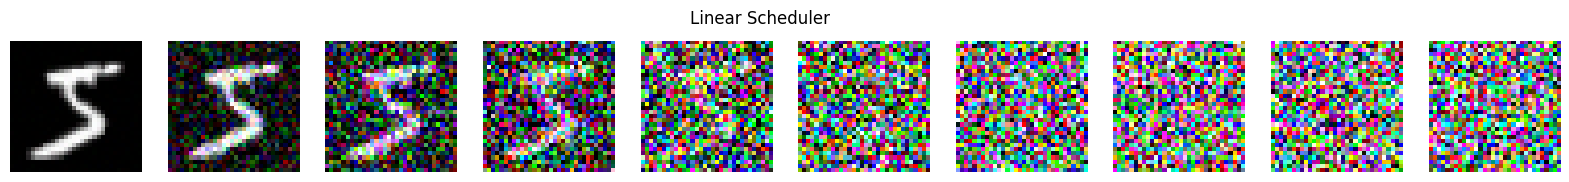
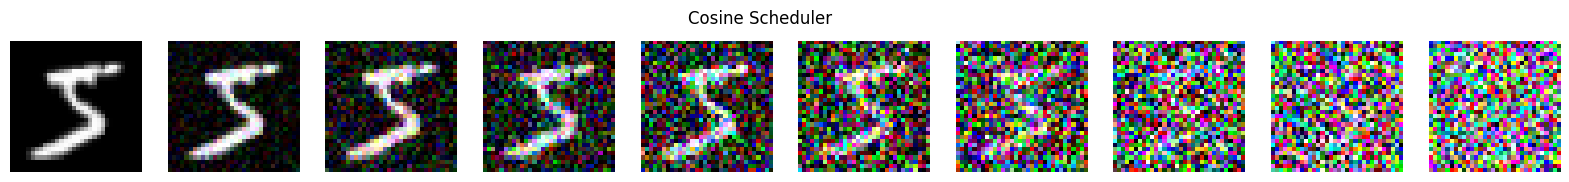

In [ ]:
T = 1000
linear_scheduler = NoiseScheduler(T, "linear")
cosine_scheduler = NoiseScheduler(T, "cosine")

for image, label in training_data:
    fig_lin, axs_lin = plt.subplots(ncols=10, figsize=(20, 2))
    fig_cos, axs_cos = plt.subplots(ncols=10, figsize=(20, 2))

    for idx, t in enumerate(np.linspace(0, T-1, 10, dtype=int)):
        x = torch.unsqueeze(image, 0)
        t = torch.tensor([t], device=x.device)

        perturbed_data = linear_scheduler.sample_marginal_prob(
            x, t
        )
        perturbed_data = unnormalize_to_zero_to_one(perturbed_data).clamp(0, 1)
        perturbed_data = rearrange(torch.squeeze(perturbed_data), "c h w -> h w c").detach().cpu().numpy()
        axs_lin[idx].imshow(perturbed_data)
        axs_lin[idx].set_axis_off()

        perturbed_data = cosine_scheduler.sample_marginal_prob(
            x, t
        )
        perturbed_data = unnormalize_to_zero_to_one(perturbed_data).clamp(0, 1)
        perturbed_data = rearrange(torch.squeeze(perturbed_data), "c h w -> h w c").detach().cpu().numpy()
        axs_cos[idx].imshow(perturbed_data)
        axs_cos[idx].set_axis_off()
    fig_lin.suptitle('Linear Scheduler')
    fig_cos.suptitle('Cosine Scheduler')
    plt.show()
    break

### Analyzing the noise scheduler (TODO 6)


How does linear scheduler and cosine scheduler differ from each other? Which one add noise faster?

Try varying `T`. Does $x_T$ become a gaussian noise when `T` is small? Why is it neccessary to set `T` to be very large?

**Ans**.

This is an expected output of the following cell. If your output is not the same, please go check that the `sample_marginal_prob` uses the noise when it is given.

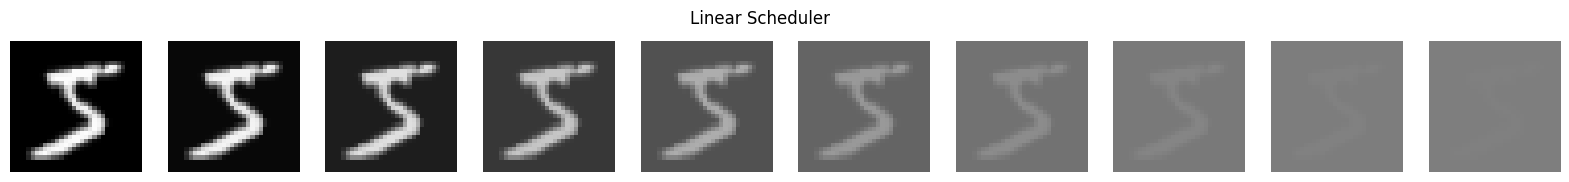
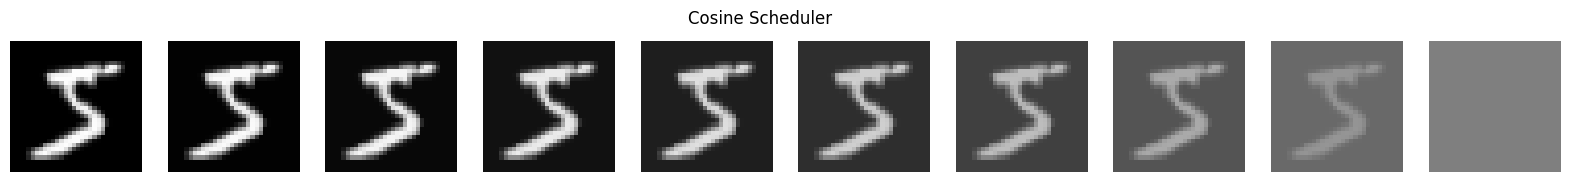

In [ ]:
for image, label in training_data:
    fig_lin, axs_lin = plt.subplots(ncols=10, figsize=(20, 2))
    fig_cos, axs_cos = plt.subplots(ncols=10, figsize=(20, 2))

    for idx, t in enumerate(np.linspace(0, T-1, 10, dtype=int)):
        x = torch.unsqueeze(image, 0)
        t = torch.tensor([t], device=x.device)

        perturbed_data = linear_scheduler.sample_marginal_prob(
            x, t, noise=torch.zeros(x.shape)
        )
        perturbed_data = unnormalize_to_zero_to_one(perturbed_data).clamp(0, 1)
        perturbed_data = rearrange(torch.squeeze(perturbed_data), "c h w -> h w c").detach().cpu().numpy()
        axs_lin[idx].imshow(perturbed_data)
        axs_lin[idx].set_axis_off()

        perturbed_data = cosine_scheduler.sample_marginal_prob(
            x, t, noise=torch.zeros(x.shape)
        )
        perturbed_data = unnormalize_to_zero_to_one(perturbed_data).clamp(0, 1)
        perturbed_data = rearrange(torch.squeeze(perturbed_data), "c h w -> h w c").detach().cpu().numpy()
        axs_cos[idx].imshow(perturbed_data)
        axs_cos[idx].set_axis_off()
    fig_lin.suptitle('Linear Scheduler')
    fig_cos.suptitle('Cosine Scheduler')
    plt.show()
    break

## Sampling

The reverse process update $x_t$ to $x_{t-1}$ based on $p_\theta(x_{t-1} | x_t) = \mathcal{N}(\mu_\theta(x_t, t), \Sigma_\theta(x_t, t))$ using $\theta$ for estimation iteratively until $t=0$. There are several famous sampling algorithm to update $x_t$ to $x_{t-1}$ such as DDPM, DDIM, DPM-Solver, and etc. The DDPM sampling is the fundamental one and you are going to reimplement it.

The algorithm below is a pseudocode of DDPM sampling method. Specifically, the DDPM model define $p_\theta(x_{t-1} | x_t)$ as
$$\begin{aligned}
p_\theta(x_{t-1} | x_t) & = \mathcal{N}(\mu_\theta, \Sigma_\theta) \\
\mu_\theta &= \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta) \\
\Sigma_\theta &= \sigma_t = \sqrt{\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t}
\end{aligned}$$

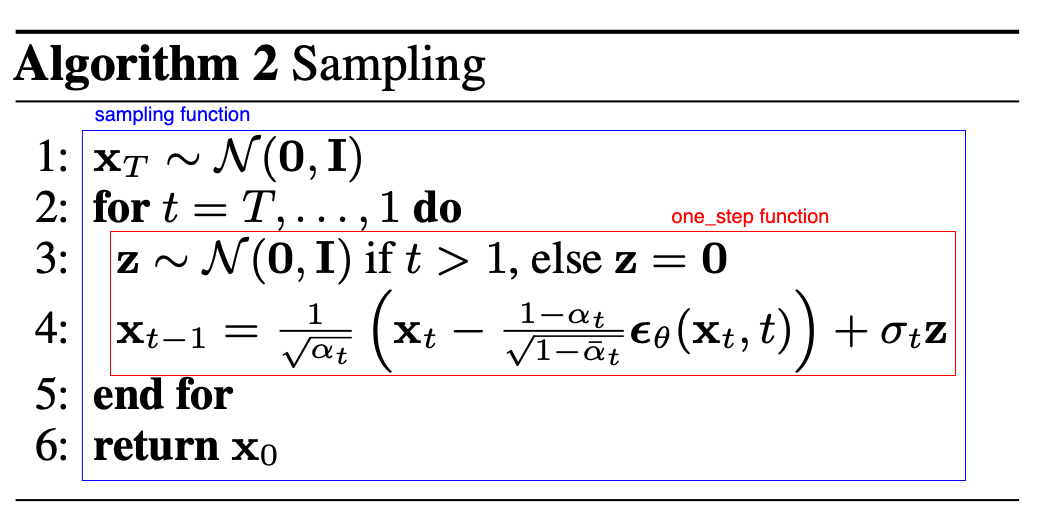



However, due to the numerical instability problem, we must re-derive $\mu_\theta$ such that it is written in the form of $x_0$ and $x_t$. To be specific, the estimated clean image $\tilde{x}_0$ can be derived from the estimated noise $\epsilon_\theta$ and it may not dwell in the image domain $[-1, 1]$ which can incur various issues such as cumulative error, etc. Therefore, it is a crucial step to derive $\tilde{x}_0$ from $\epsilon_\theta$ and clip it before updating $x_t$.

The following is a step to represent $\mu_\theta$ in form of $x_t$ and $x_0$.  Since ($p(x_t |x_0, t) = \mathcal{N}(\sqrt{\bar{\alpha}_t}x_0, (1-\bar{\alpha}_t) \mathbf{I})$), the estimated clean noise $\tilde{x}_0$ is:

$$\begin{aligned}
\tilde{x}_0 &= \frac{1}{\sqrt{\bar{\alpha}_t}} (x_t - \sqrt{1-\bar{\alpha}_t}\epsilon_\theta) \end{aligned}$$

As $ \mu_\theta = \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{\sqrt{1-\bar{\alpha}_t}}\epsilon_\theta)$ and $\epsilon_\theta = \frac{x_t - \sqrt{\bar{\alpha}_t}\tilde{x}_0}{\sqrt{1-\bar{\alpha}_t}}$ (from the equation above). $\mu_\theta $ becomes:

$$
\begin{aligned}
\mu_\theta &= \frac{1}{\sqrt{\alpha_t}} (x_t - \frac{1-\alpha_t}{1-\bar{\alpha}_t} (x_t - \sqrt{\bar{\alpha}_t}\tilde{x}_0)) \\
&= \frac{1}{\sqrt{\alpha_t}} (\frac{\alpha_t - \bar{\alpha}_t}{1 - \bar{\alpha}_t} x_t - \frac{1-\alpha_t}{1-\bar{\alpha}_t} \sqrt{\bar{\alpha}_t} \tilde{x}_0) \\
&= \sqrt{\alpha_t} \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} x_t - \sqrt{\bar{\alpha}_{t-1}} \frac{1-\alpha_t}{1-\bar{\alpha}_t}  \tilde{x}_0
\end{aligned}
$$

Since $p_\theta(x_{t-1} | x_t) = \mathcal{N}(\mu_\theta, \Sigma_\theta) = \mu_\theta + \sigma_t\mathbf{z} $, $x_{t-1}$ is
$$x_{t-1} = \sqrt{\alpha_t} \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} x_t - \sqrt{\bar{\alpha}_{t-1}} \frac{1-\alpha_t}{1-\bar{\alpha}_t}  \tilde{x}_0 + \sigma_t \mathbf{z} $$

**Instruction**

TODO 7: perform one step update (sample $x_{t-1} \sim p_\theta(x_{t-1}|x_t)$) \

$$\text{x$\_$mean} = \sqrt{\alpha_t} \frac{1 - \bar{\alpha}_{t-1}}{1 - \bar{\alpha}_t} x_t - \sqrt{\bar{\alpha}_{t-1}} \frac{1-\alpha_t}{1-\bar{\alpha}_t}  \tilde{x}_0$$
$$\sigma_t = \sqrt{\frac{1-\bar{\alpha}_{t-1}}{1-\bar{\alpha}_t} \beta_t}$$
$$\text{x$\_$update} = \text{x$\_$mean} + \sigma_t \mathbf{z}$$

In [ ]:
class DDPMSampler:
    def __init__(self, pred_x0_func, schedule):
        """ Sampler Abstract class

        Args:
            pred_x0_func: A function that predicts clean image x_0 given x_t (tensor shape (B, C, H, W)) and t (tensor shape (B)).
            schedule: A diffusion scheduler contains alpha and beta parameters.

        """
        self.pred_x0_func = pred_x0_func
        self.schedule = schedule

    def update_step(self, x_t, t, context):
        """One step update

        Update x_t to x_{t-1} following DDPM update rule.

        Args:
            x_t (torch.tensor): An image at diffusion step t.
            t (torch.tensor): A diffusion timestep.

        Returns:
            x_mean (torch.tensor): The noiseless mean of the reverse process (not adding noise yet)
            x_update (torch.tensor): The updated image from a reverse process (mean + noise)

        """
        # TODO 7: perform one step update (sample x_{t-1} from p_\theta(x_{t-1} | x_t))
        # Note: This function return x_mean and x_update (the sampled x_{t-1}).
        #       At the last step of reverse process, we use x_mean insetad of x_update because
        #       we assume that it is noiseless.
        z = torch.randn_like(x_t)
        pred_x_0 = self.pred_x0_func(x_t, t, context) # the output of pred_x0_func is already clipped. You do not need to clip it anymore.

        # calculate the mean and std of p_\theta(x_{t-1} | x_t) where the mean is calculate from the equation above (in form of x_0).
        x_mean = None


        # sample x_{t-1} using the reparameterization trick
        x_update = None
        return x_mean, x_update


    def sampling(self, x_T, context, return_all=False):
        """Sampling new image from prior sample

        Args:
            x_T (torch.tensor): A prior sample, sampling from Standard Normal Distribution.
            return_all (bool): If True, return every x_t for all t. Otherwise, only return x_0. Default to False.

        Returns:
            x_0 (torch.tensor): The generated images given prior samples, assuming x_0 is noiseless.

        """
        x_t = x_T
        T = self.schedule.T
        reverse_process = [x_T]
        for t in reversed(range(0, T)):
            vec_t = torch.ones(x_T.shape[0], dtype=int, device=x_T.device) * t
            x_mean, x_t = self.update_step(x_t, vec_t, context)
            # append x_t to reverse_process (Do not forget the last step.)
            reverse_process.append(x_t if t > 0 else x_mean)

        # if return_all is True then return reverse_process (list of x_t), otherwise return x_0
        reverse_process = torch.cat(reverse_process, dim=0) if return_all else reverse_process[-1]
        return reverse_process  # In the last step, we assume x_0 is noiseless.

For a sanity check, we will set predicted $x_0$ function to predict the ground truth. The following code perform a reverse process.

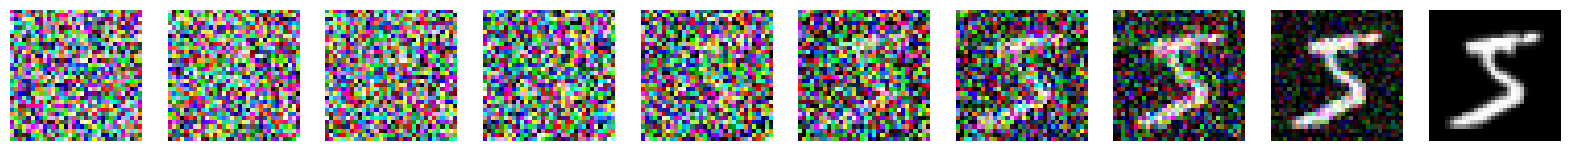

In [ ]:
for image, label in training_data:
    fig, axs = plt.subplots(ncols=10, figsize=(20, 2))


    x = torch.unsqueeze(image, 0)
    t = torch.tensor([t], device=x.device)

    pred_gt = lambda x_t, t, context: x
    sampler = DDPMSampler(pred_gt, linear_scheduler)
    x_T = linear_scheduler.prior_sampling(RESOLUTION)

    perturbed_data = sampler.sampling(x_T, return_all=True, context=torch.zeros(x_T.shape[0]))
    perturbed_data = unnormalize_to_zero_to_one(perturbed_data).clamp(0, 1)

    for idx, t in enumerate(np.linspace(0, T, 10, dtype=int)):
        x_t = rearrange(torch.squeeze(perturbed_data[t]), "c h w -> h w c").detach().cpu().numpy()

        axs[idx].imshow(x_t)
        axs[idx].set_axis_off()


    plt.show()
    break

## Model Architecture

Due to its promising result in the computer vision field, Unet was adapted to the diffusion model to predict the noise in noisy images. In addition, the Unet model in diffusion was slightly modified to enable the controllable property by adding an attention block.

To make it simple, we divide the Unet model into 4 modules.
1. Upsample & Downsample
2. Positional Embedding
3. ResnetBlock
4. Attention



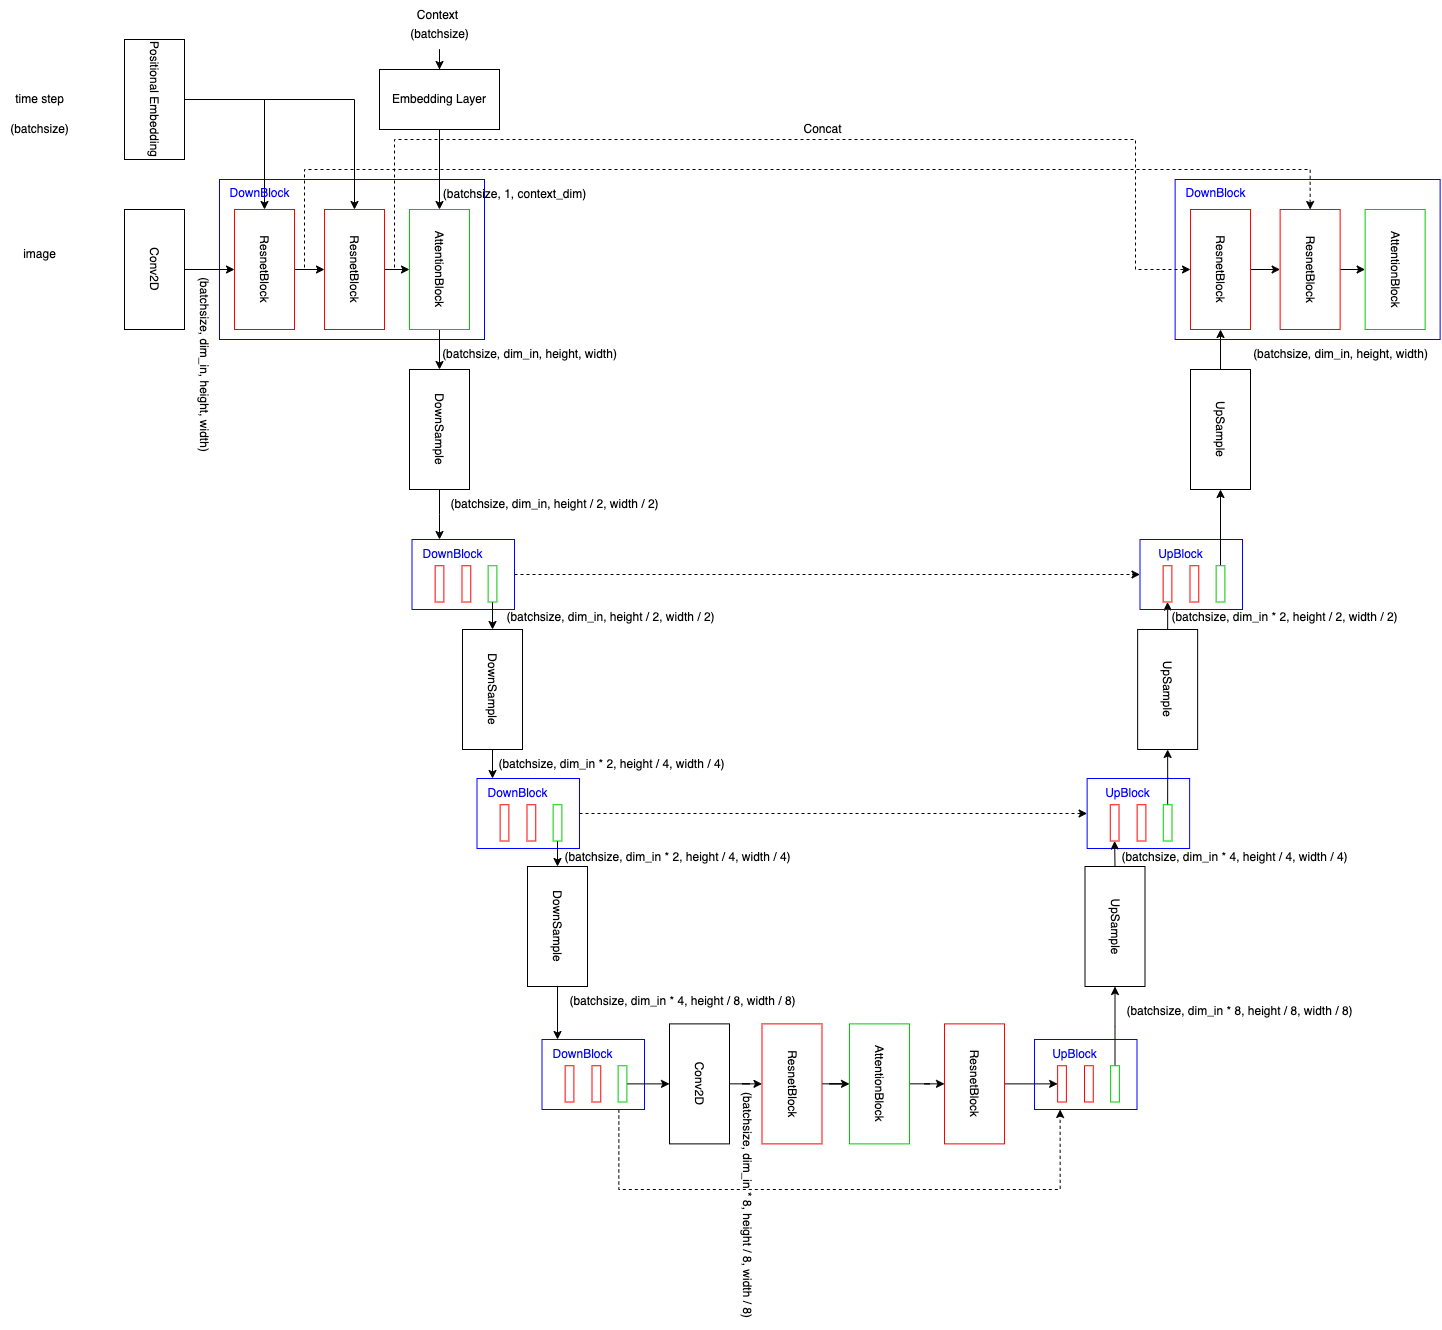

### Downsample and Upsample

The downsample module is responsible for reducing the features size while the upsample module is for expanding the features back.

The upsample layer consists of two components:
1. Upsample module with the default setting and scale factor of 2.
2. Convolution module (kernel size = 3, stride = 1, and padding = 1) for extracting the feature.

On the other hand, the downsample layer is just a single convolution module (kernel size = 3, stride = 2, and padding = 1).

In [ ]:
import math
import torch.nn as nn
import torch.nn.functional as F
from einops.layers.torch import Rearrange
from functools import partial

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if callable(d) else d

def Upsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Upsample(scale_factor = 2, mode = 'nearest'),
        nn.Conv2d(dim, default(dim_out, dim), 3, padding = 1)
    )

def Downsample(dim, dim_out = None):
    return nn.Sequential(
        nn.Conv2d(dim, default(dim_out, dim), 3, padding=1, stride=2)
    )

### Sinusoidal Positional Embedding

The sinusoidal positional embedding layer is a layer used for incorporating temporal information into an embedding. Similar to the positional embedding in a transformer, it uses the following equations:

$PE_{(timestep, 2i)} = \sin (timestep/10000^{2i/dim})$

$PE_{(timestep, 2i+i)} = \cos (timestep/10000^{2i/dim})$

In [ ]:
class SinusoidalPosEmb(nn.Module):
    def __init__(self, dim, theta = 10000):
        super().__init__()
        self.dim = dim
        self.theta = theta

    def forward(self, x):
        device = x.device
        half_dim = self.dim // 2
        emb = math.log(self.theta) / (half_dim - 1)
        emb = torch.exp(torch.arange(half_dim, device=device) * -emb)
        emb = x[:, None] * emb[None, :]
        emb = torch.cat((emb.sin(), emb.cos()), dim=-1)
        return emb

### ResnetBlock

The ResnetBlock can be separated into 3 modules:
1. timestep extraction: A module is used to extract the feature in timestep embedding
2. ConvBlock1: It composes of convolution layer followed by groupnorm and activation function. In the first block, we perform an additional operation between the features from the timestep extraction module and the features after convolution and groupnorm (before performing activation function).
3. ConvBlock2: Similar to ConvBlock1 but ignore the timestep embedding
4. ConvResidual: It performs a residual connection between the previous module and the input (which is passed to convolutional layer to ensure that the dimension is aligned.).

Figure ResnetBlock

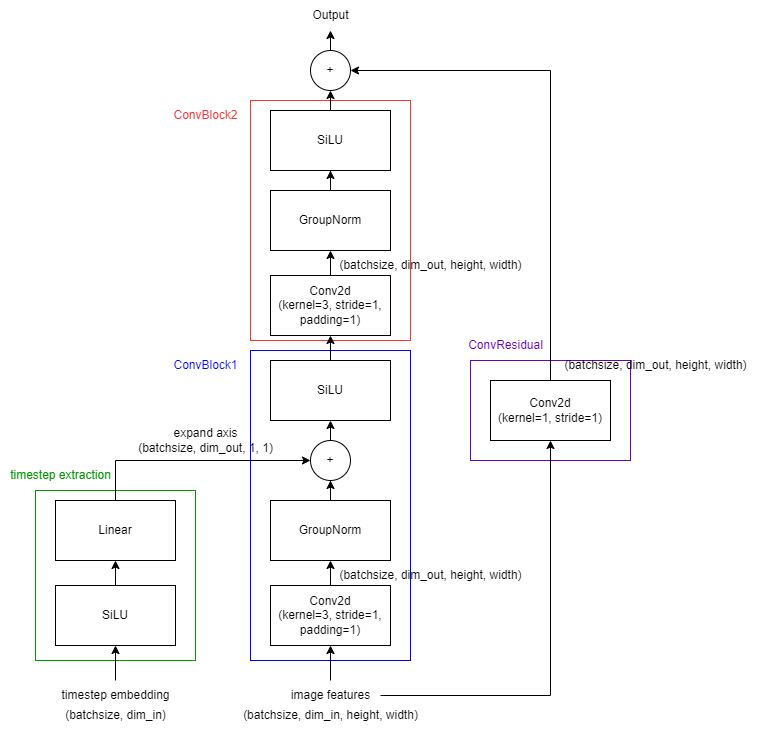


In [ ]:
# building block modules

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            x += scale_shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim = None, groups = 8):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_emb_dim, dim_out)
        ) if exists(time_emb_dim) else None

        self.block1 = Block(dim, dim_out, groups = groups)
        self.block2 = Block(dim_out, dim_out, groups = groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb = None):

        scale_shift = None
        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            time_emb = rearrange(time_emb, 'b c -> b c 1 1')
            scale_shift = time_emb

        h = self.block1(x, scale_shift = scale_shift)

        h = self.block2(h)

        return h + self.res_conv(x)


#### TODO 8: What does this line `time_emb = rearrange(time_emb, 'b c -> b c 1 1')` do in ResnetBlock? Where does it relate to the above figure?

Ans

### Attention

To control the diffusion model, we insert the attention block into the unet model. The label in MNIST dataset is transform into embedding through the embedding layer and then it is passed into attention to perform a cross attention to control the output based on the the label.

<!-- The attention block consists of:
1. Features extraction
2. Self-attention
3. Cross-attention
4. Linear Layer -->

The architecture of AttentionBlock:

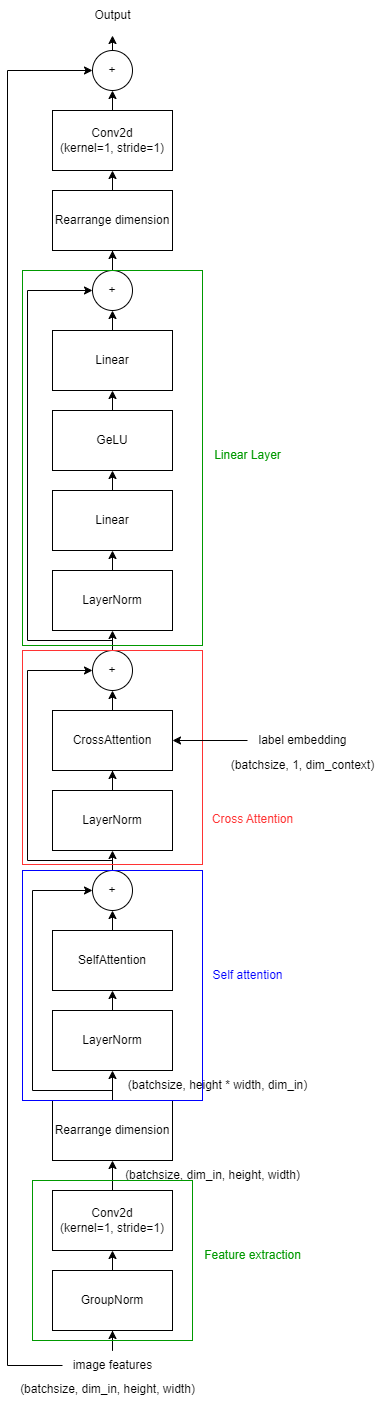

**Note**: The image features is rearranged before passing through self-attention layer. We observe the spatial dimension (width and height) as a sequence length.

#### TODO 9: What is the output's shape of `torch.einsum("b h i d, b h j d -> b h i j", q, k)`? How is each entry in the output calculated? Given $Q \in \mathcal{R}^{B, H, I, D}$ and $K \in \mathcal{R}^{B, H, J, D}$.

Ans

The format of the answer should be similar to this: \
The output of matrix multiplication:
$$A \times B = C$$
where $A \in \mathcal{R}^{m, n}$ and $B \in \mathcal{R}^{n, p}$
- Shape of C -> $C \in \mathcal{R}^{m, p}$
- The entry in C -> $c_{i,j} = \sum_{k=1}^n a_{i,k} b_{k,j}$ for $i=1,\dots, m$ and $j=1,\dots,p$

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, n_heads, dim):
        """ Multi-head self attention

        Args:
            n_heads (int): The number of distinct representation to learn.
            dim (int): The number of channels (eg. the size of embedding vector)

        """
        super().__init__()
        self.n_heads = n_heads
        self.dim = dim
        self.dim_head = dim // n_heads
        _dim = self.dim_head * n_heads
        self.to_qkv = nn.Linear(dim, 3 * _dim, bias=False)
        self.linear = nn.Linear(_dim, dim)

    def forward(self, x):
        qkv = self.to_qkv(x)
        q, k, v = tuple(rearrange(qkv, "b l (k h d) -> k b h l d", h=self.n_heads, k=3)) # decompose to q, k, v

        # TODO 9: What does torch.einsum do?
        attention = F.softmax(torch.einsum("b h i d, b h j d -> b h i j", q, k) / (self.dim_head ** 0.5), dim=-1)
        output = torch.einsum("b h i j, b h j d -> b h i d", attention, v)
        output = rearrange(output, "b h l d -> b l (h d)")
        output = self.linear(output)
        return output

class MultiHeadCrossAttention(nn.Module):
    def __init__(self, n_heads, dim_emb, dim_cross):
        """ Multi-head cross attention

        Args:
            n_heads (int): The number of distinct representation to learn.
            dim_emb (int): The number of channels in embedding for query.
            dim_cross (int): The number of channels in embedding for key and value.
        """
        super().__init__()
        self.n_heads = n_heads
        self.dim_emb = dim_emb
        self.dim_cross = dim_cross
        self.dim_head = dim_emb // n_heads
        _dim = self.dim_head * n_heads
        self.to_q = nn.Linear(dim_emb, _dim, bias=False)
        self.to_kv = nn.Linear(dim_cross, 2*_dim, bias=False)
        self.linear = nn.Linear(_dim, dim_emb)

    def forward(self, x, context):
        q = self.to_q(x)
        kv = self.to_kv(context)

        q = rearrange(q, "b l (h d) -> b h l d", h=self.n_heads)
        k, v = tuple(rearrange(kv, "b l (k h d) -> k b h l d", k=2, h=self.n_heads))

        attention = F.softmax(torch.einsum("b h i d, b h j d -> b h i j", q, k) / (self.dim_head ** 0.5), dim=-1)
        output = torch.einsum("b h i j, b h j d -> b h i d", attention, v)
        output = rearrange(output, "b h l d -> b l (h d)")
        output = self.linear(output)
        return output

In [ ]:
class AttentionBlock(nn.Module):
    def __init__(self, n_heads, in_channels, context_channels=128):
        super().__init__()
        self.groupnorm = nn.GroupNorm(32, in_channels, eps=1e-6)
        self.conv_input = nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0)

        self.layernorm_1 = nn.LayerNorm(in_channels)
        self.attention_1 = MultiHeadSelfAttention(n_heads, in_channels)
        self.layernorm_2 = nn.LayerNorm(in_channels)
        self.attention_2 = MultiHeadCrossAttention(n_heads, in_channels, context_channels)
        self.layernorm_3 = nn.LayerNorm(in_channels)
        self.linear_geglu_1  = nn.Linear(in_channels, 4 * in_channels) # 4 * in_channels * 2
        self.linear_geglu_2 = nn.Linear(4 * in_channels, in_channels)

        self.conv_output = nn.Conv2d(in_channels, in_channels, kernel_size=1, padding=0)

    def forward(self, x, context):
        residue_long = x

        x = self.groupnorm(x)
        x = self.conv_input(x)

        n, c, h, w = x.shape
        x = x.view((n, c, h * w))   # (n, c, hw)
        x = x.transpose(-1, -2)  # (n, hw, c)

        residue_short = x
        x = self.layernorm_1(x)
        x = self.attention_1(x)
        x += residue_short

        residue_short = x
        x = self.layernorm_2(x)
        x = self.attention_2(x, context)
        x += residue_short

        residue_short = x
        x = self.layernorm_3(x)
        # x, gate = self.linear_geglu_1(x).chunk(2, dim=-1)
        # x = x * F.gelu(gate)
        x = self.linear_geglu_1(x)
        x = F.gelu(x)
        x = self.linear_geglu_2(x)
        x += residue_short

        x = x.transpose(-1, -2)  # (n, c, hw)
        x = x.view((n, c, h, w))    # (n, c, h, w)

        return self.conv_output(x) + residue_long


### Unet

We combine every modules to build a Unet.

In [ ]:
def cast_tuple(t, length = 1):
    if isinstance(t, tuple):
        return t
    return ((t,) * length)

def divisible_by(numer, denom):
    return (numer % denom) == 0
# model

class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim = None,
        out_dim = None,
        dim_mults = (1, 2, 4, 8),
        channels = 3,
        self_condition = False,
        resnet_block_groups = 8,
        sinusoidal_pos_emb_theta = 10000,
        attn_heads = 4,
        context_dim = 768,
    ):
        super().__init__()

        # determine dimensions

        self.channels = channels
        self.self_condition = self_condition
        input_channels = channels * (2 if self_condition else 1)

        init_dim = default(init_dim, dim)
        self.init_conv = nn.Conv2d(input_channels, init_dim, 7, padding = 3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))

        block_klass = partial(ResnetBlock, groups = resnet_block_groups)

        # time embeddings

        time_dim = dim * 4


        sinu_pos_emb = SinusoidalPosEmb(dim, theta = sinusoidal_pos_emb_theta)
        fourier_dim = dim

        self.time_mlp = nn.Sequential(
            sinu_pos_emb,
            nn.Linear(fourier_dim, time_dim),
            nn.GELU(),
            nn.Linear(time_dim, time_dim)
        )

        # attention
        num_stages = len(dim_mults)

        FullAttention = partial(AttentionBlock, context_channels=context_dim, n_heads=attn_heads)

        # layers

        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            attn_klass = FullAttention

            self.downs.append(nn.ModuleList([
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                block_klass(dim_in, dim_in, time_emb_dim = time_dim),
                attn_klass(in_channels = dim_in),
                Downsample(dim_in, dim_out) if not is_last else nn.Conv2d(dim_in, dim_out, 3, padding = 1)
            ]))

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)
        self.mid_attn = FullAttention(in_channels = mid_dim)
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim = time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out)):
            is_last = ind == (len(in_out) - 1)

            attn_klass = FullAttention

            self.ups.append(nn.ModuleList([
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                block_klass(dim_out + dim_in, dim_out, time_emb_dim = time_dim),
                attn_klass(in_channels = dim_out),
                Upsample(dim_out, dim_in) if not is_last else  nn.Conv2d(dim_out, dim_in, 3, padding = 1)
            ]))

        default_out_dim = channels
        self.out_dim = default(out_dim, default_out_dim)

        self.final_res_block = block_klass(dim * 2, dim, time_emb_dim = time_dim)
        self.final_conv = nn.Conv2d(dim, self.out_dim, 1)

    @property
    def downsample_factor(self):
        return 2 ** (len(self.downs) - 1)

    def forward(self, x, time, context):
        assert all([divisible_by(d, self.downsample_factor) for d in x.shape[-2:]]), f'your input dimensions {x.shape[-2:]} need to be divisible by {self.downsample_factor}, given the unet'

        if self.self_condition:
            x_self_cond = default(x_self_cond, lambda: torch.zeros_like(x))
            x = torch.cat((x_self_cond, x), dim = 1)

        x = self.init_conv(x)
        r = x.clone()

        t = self.time_mlp(time)

        h = []

        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            h.append(x)

            x = block2(x, t)
            x = attn(x, context)

            h.append(x)

            x = downsample(x)

        x = self.mid_block1(x, t)
        x = self.mid_attn(x, context)
        x = self.mid_block2(x, t)

        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim = 1)
            x = block1(x, t)

            x = torch.cat((x, h.pop()), dim = 1)
            x = block2(x, t)
            x = attn(x, context)

            x = upsample(x)

        x = torch.cat((x, r), dim = 1)

        x = self.final_res_block(x, t)
        return self.final_conv(x)

In [ ]:
from torchinfo import summary
model = Unet(
    dim = 32,
    dim_mults = (1, 2, 4, 8),
)


summary(model, input_size=[(32, 3, 32, 32), (32,), (32, 10, 768)], dtypes=[torch.float, torch.long, torch.float], depth=1)

## Diffusion

In this section, we are going to assemble every components into diffusion class.

The functions in Diffusion class
*   predict_x0: transforming the noise predicted from the model into $\tilde{x}_0$.
$\tilde{x}_0 = \frac{1}{\sqrt{\bar{\alpha}_t}} (x_t - \sqrt{1-\bar{\alpha}_t}\epsilon_\theta)$
*   p_losses: calculate loss for one step update (the algorithm of training process is shown below)
*   forward: a forward pass of the model (The output is the noise in $x_t$)
*   sample: perform a reverse process

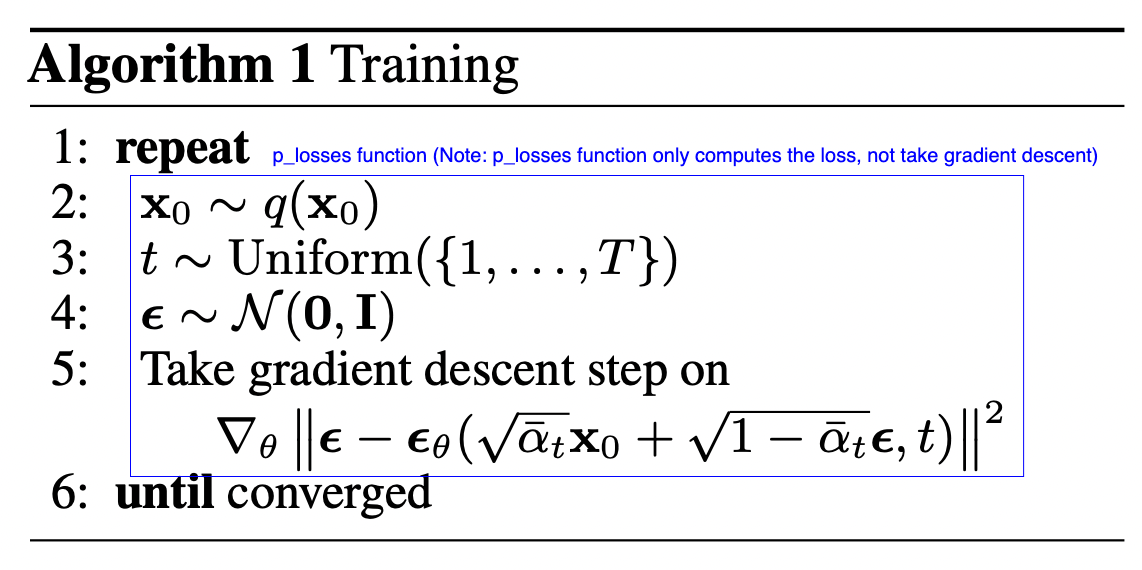


**Instruction**

TODO 10: implement predict_x0 function \
TODO 11: implement p_losses function

In [ ]:
import torch.nn as nn

class Diffusion(nn.Module):
    def __init__(self, model, scheduler, resolution, sampler="ddpm", loss="mse", device="cuda"):
        super().__init__()
        self.model = model
        self.scheduler = scheduler
        self.resolution = resolution
        self.device = device

        if loss == "mse":
            self.loss_fn = nn.MSELoss()
        elif loss == "mae":
            self.loss_fn = nn.L1Loss()
        else:
            raise NotImplementedError

        if sampler == "ddpm":
            self.sampler = DDPMSampler(self.predict_x0, scheduler)
        else:
            raise NotImplementedError

    def predict_x0(self, x_t, t, context):
        noise = self.model(x_t, t, context).detach()
        # TODO 10: convert the noise into x_0
        # Note: Do not forget to clip the value of the predicted x_0 to be in the range of [-1, 1] (using torch.clamp).
        x_0 = None
        return x_0

    def p_losses(self, x_0, context):
        # TODO 11: calculate loss of one step
        # 3 Steps:
        #   1. random a gaussian noise (z).
        #   2. sample time step uniformly from [0, T] where T is an attribute in self.scheduler
        #   3. sample x_t using scheduler.sample_marginal_prob where the noise come from step 1.
        #   4. predict noise give x_t, t, context using self.model
        #   5. calculate loss given predicted noise and noise from step 1 uinsg self.loss_fn.
        loss = None
        return loss

    def forward(self, x_t, t, context):
        return self.model(x_t, t, context)

    def sample(self, batch_size, context):
        x_T = self.scheduler.prior_sampling(self.resolution, batch_size=batch_size, num_channels=3).to(self.device)
        sampler = self.sampler.sampling(x_T, context).detach().cpu().numpy().squeeze()
        return sampler


    def to(self, device):
        self.device = device
        self.model.to(device)
        self.scheduler.to(device)

## Training

After building a diffusion model, we create trainer class to train our model.

These are the important functions that you should read:
1. `_step` (TODO 12): A one step function that return loss of one step update.
2. `train_loop`: A function to train the model for one epoch.
3. `val_loop`: A valdation function
4. `sampling_image`: Sample new images using reverse process

**Note**: We will control the diffusion model using the `self.embedding=nn.Embedding` to transform the digit into embedding. Then the embedding is passed through the Unet model and perform the cross attention with the image features.

**Instruction**

TODO 12: implement `_step` function

In [ ]:
class Trainer:
    def __init__(
        self,
        model,
        train_dataloader,
        val_dataloader,
        ckpt_path,
        resolution=None,
        lr=1e-4,
        device="cuda",
    ):
        self.model = model
        self.embedding = nn.Embedding(10, 768) # MNIST has 10 classes and embedding size is 768.

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.resolution = next(iter(train_dataloader))[0].shape[-2:] if resolution == None else resolution

        self.lr = lr
        self.configure_optimizers()

        self.ckpt_path = ckpt_path
        self.device = device
        self.epoch = 0
        self.mode = "train"

        self.to(device)

    def configure_optimizers(self):
        """Construct Optimizer"""
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

    def _step(self, batch):
        """One step forward pass

        Args:
            batch (Tuple[torch.tensor]): A mini-batch data to be processed. The first index must contain images
                and the latter are the corresponded label. The shape of image is (B, C, H, W),
                while the shape of label is (B).

        Returns:
            loss (torch.tensor): A loss value to be used for updating the model.

        """
        x, context = batch
        # TODO 12: calculate the loss given batch
        # Pseudo code:
        #   1. acquire the context embedding through self.embedding
        #   2. expand dimension such that the shape of embedding is (batch_size, 1, dimension)
        #   3. calculate loss using self.model.p_losses
        losses = None
        return losses

    def optimizer_step(self, loss):
        """Update model based on the given loss.

        Args:
            loss (torch.tensor): A loss value to be differentiated (Note: must be able to compute a gradient.)

        """
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

    def train_loop(self, epoch):
        """One epoch training loop.

        Args:
            epoch (int): A current epoch.

        Returns:
            train_loss (np.array): A list of loss in each batch.

        """
        self.train()
        with tqdm(self.train_dataloader, unit="batch", leave=False) as tbatch:
            train_loss = []
            for batch in tbatch:
                tbatch.set_description(f"Epoch {epoch+1}")
                batch = list(
                    map(lambda x: x.to(self.device), batch)
                )  # allocate data on the pre-defined device.
                loss = self._step(batch)  # forward pass and calculate loss
                self.optimizer_step(loss)  # backward pass / updating the parameters
                train_loss.append(loss.item())
                tbatch.set_postfix(loss=loss.item())
            train_loss = np.array(train_loss)
        return train_loss

    def val_loop(self, epoch):
        """One epoch validating loop.

        Args:
            epoch (int): A current epoch.

        Returns:
            train_loss (np.array): A list of loss in each batch.

        """
        self.eval()
        # with self.ema.average_parameters():  # Copy EMA weight to model and restore after exiting `with`
        with tqdm(self.val_dataloader, unit="batch", leave=False) as tbatch:
            val_loss = []
            for batch in tbatch:
                tbatch.set_description(f"Epoch {epoch+1}")
                batch = list(
                    map(lambda x: x.to(self.device), batch)
                )  # allocate data on the pre-defined device.
                loss = (
                    self._step(batch).detach().cpu()
                )  # forward pass and calculate loss
                val_loss.append(loss.item())
                tbatch.set_postfix(loss=loss.item())
            val_loss = np.array(val_loss)
        return val_loss

    def fit(self, epochs, num_val_sampler=2, ckpt_path=None, resume=False, sampling_round=10):
        """Train the model

        Args:
            epochs (int): A number of epochs to be trained.

        Returns:
            train_epoch (np.array): A list of training loss in each epoch.
            val_epoch (np.array): A list of validation loss in each epoch.

        """
        best_val_loss = None
        ckpt_path = self.ckpt_path if ckpt_path is None else ckpt_path
        last_path = os.path.join(ckpt_path, "last_weight.ckpt")
        print("Save:", last_path)
        self.to(self.device)

        train_loss_epoch = []
        val_loss_epoch = []

        epochs = range(self.epoch, self.epoch+epochs) if resume == True else range(epochs)
        for epoch in epochs:
            self.epoch = epoch

            train_loss = self.train_loop(epoch) # Training Model
            val_loss = self.val_loop(epoch) # Evaluating Model

            if (epoch+1)%sampling_round == 0 or epoch == 0:
                self.sampling_image(num_val_sampler) # Generating new images

            print(
                f"Epoch {epoch+1}: Train Loss {train_loss.mean().item()}, Val Loss {val_loss.mean().item()}"
            )
            train_loss_epoch.append(train_loss.mean().item())
            val_loss_epoch.append(val_loss.mean().item())

            torch.cuda.empty_cache() # Clear GPU cache

        self.save(last_path)
        train_loss_epoch = np.array(train_loss_epoch)
        val_loss_epoch = np.array(val_loss_epoch)
        return train_loss_epoch, val_loss_epoch

    def sampling_image(self, num_images):
        """Sampling new images

        The sampling images was exhibited in a column format, using matplotlib.

        Args:
            num_images (int): A number of images to be generated.

        """
        self.eval()
        fig, axs = plt.subplots(ncols=num_images)
        label = torch.randint(0, 10, (num_images,), device=self.device)
        context = self.embedding(label).unsqueeze(1)
        sampled_images = self.model.sample(batch_size = num_images, context=context)
        for idx_sampler in range(num_images):
            axs[idx_sampler].imshow(rearrange(unnormalize_to_zero_to_one(sampled_images[idx_sampler]), "c h w -> h w c"), cmap="gray")
            axs[idx_sampler].set_title(label[idx_sampler].item())
            axs[idx_sampler].set_axis_off()
        plt.show()

    def save(self, path):
        """ Save trainer state """
        path = self.ckpt_path if path is None else path
        torch.save({
            "epoch": self.epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "embedding": self.embedding.state_dict(),
        }, path)

    def load(self, path):
        """ Load trainer state """
        checkpoint = torch.load(path)
        self.epoch = checkpoint["epoch"]
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.embedding.load_state_dict(checkpoint["embedding"])

    def train(self):
        """ Set trainer to train mode """
        if self.mode != "train":
            self.model.train()
            self.mode = "train"

    def eval(self):
        """ Set trainer to evaluate mode """
        if self.mode != "eval":
            self.model.eval()
            self.mode = "eval"

    def to(self, device):
        """Set a computational device (eg. cpu or cuda).

        Args:
            device (str): A computational device to be computed on.

        """
        self.device = device
        self.model.to(device)
        self.embedding.to(device)

    def set_dataset(self, train_dataloader, val_dataloader, resolution=None):
        """Set a new dataset.

        Args:
            train_dataloader (torch.utils.data.DataLoader): A new training set.
            val_dataloader (torch.utils.data.DataLoader): A new validation set.
            resolution (Tuple[int], optional): A new resolution of the images in the given dataset. If None,
                it was set to the size of the first image. Default to None.

        """
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.resolution = next(iter(train_dataloader))[0].shape[-2:] if resolution == None else resolution

    def parameters(self):
        return [p for p in self.model.parameters() if p.requires_grad]


In [ ]:
model = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
)

diffusion = Diffusion(
    model,
    linear_scheduler,
    resolution=(32, 32),
)

trainer_config = {
    "model": diffusion,
    "train_dataloader": train_dataloader,
    "val_dataloader": test_dataloader,
    "device": "cuda",
    "ckpt_path": "./",
    "lr": 8e-5,
}

trainer = Trainer(**trainer_config)

In [ ]:
epoch = 10
train_losses, val_losses = trainer.fit(epoch)

Plot training and validation loss

Loss of the last epoch should be around 0.0085 - 0.009.

In [ ]:
plt.plot(range(epoch), train_losses, label="training loss")
plt.plot(range(epoch), val_losses, label="validation loss")
plt.legend()
plt.show()

## Inference

In [ ]:
trainer.eval()
fig, axs = plt.subplots(nrows=10, ncols=10)
for digit in range(10):
    label = torch.ones(10, device=trainer.device, dtype=torch.int) * digit
    context = trainer.embedding(label).unsqueeze(1)
    sampled_images = trainer.model.sample(batch_size = 10, context=context)
    for i in range(10):
        axs[digit][i].imshow(rearrange(unnormalize_to_zero_to_one(sampled_images[i]), "c h w -> h w c"), cmap="gray")
        # axs[digit].set_title(label[].item())
        axs[digit][i].set_axis_off()
plt.show()

# Part 2: Low Rank Adapter (LORA)

With the discovery of the scaling property in the deep learning model, several researchers tend to increase the size of the deep learning model to obtain the emergent property, especially in the natural language processing (NLP) field. For example, the GPT3 contains 175 billion parameters, making it impossible to fine-tune. This trend obstructs students like us from transferring these enormous foundation models on a single GPU (or small resources). Therefore, to alleviate this problem, some researchers invent new methods to fine-tune the model, called parameter-efficient transfer learning, which allows us to train large models on limited resources. Its benefits exist not only in the training process but also during deployment. After fine-tuning the model, we need to save only a small amount of parameters (LoRA weights), allowing us to deploy the foundation model to various downstream tasks using a small amount of storage. One of the prevailing methods is Low Rank Adaptation (LORA).

In this section, we are going to introduce the Low-Rank Adaptation. You are assigned to implement the LORA on the MaskTransfomer model trained by HuggingFace. The model is trained on ADE20k semantic segmentation, and we will transfer this foundation model to the satellite building segmentation dataset using the LoRA method. For the details of MaskFormer, please visit this site: https://huggingface.co/facebook/maskformer-swin-tiny-ade.

## Downloading the pre-trained MaskFormer model and Satellite-Building-Segmentation Dataset

In [ ]:
from PIL import Image, ImageDraw
import torch.nn as nn
import torch
import torch.nn.functional as F
from transformers import MaskFormerConfig, MaskFormerModel, MaskFormerImageProcessor, MaskFormerForInstanceSegmentation

from datasets import load_dataset

model_name = "facebook/maskformer-swin-tiny-ade"
ds = load_dataset("keremberke/satellite-building-segmentation", name="full")

## Preprocessing Data

In [ ]:
def create_mask(data):
    image = data["image"]
    mask = Image.new(mode="RGB", size=image.size, color=(0, 0, 0))
    draw = ImageDraw.Draw(mask)

    instance_id = 1
    for category_id, polygon_point in zip(data["objects"]["category"], data["objects"]["segmentation"]):
        if len(polygon_point) > 1:
            print(polygon_point)
            raise IndexError
        draw.polygon(polygon_point[0], fill=(category_id+1, instance_id, 0))
        instance_id += 1
    return mask

def unnormalize_image(image, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]):
    image = image * np.array([0.229, 0.224, 0.225])[:, None, None]
    image = image + np.array([0.485, 0.456, 0.406])[:, None, None]
    return image

In [ ]:
from torch.utils.data import DataLoader, Dataset
import albumentations as A
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
from einops import rearrange

class ImageSegmentationDataset(Dataset):
    def __init__(self, dataset, processor, transform=None):
        self.dataset = dataset
        self.processor = processor
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        # Convert the PIL Image to a NumPy array
        image = np.array(self.dataset[idx]["image"].convert("RGB"))

        # Get the pixel wise instance id and category id maps
        # of shape (height, width)
        instance_seg = np.array(create_mask(self.dataset[idx]))[..., 1]
        class_id_map = np.array(create_mask(self.dataset[idx]))[..., 0]
        class_labels = np.unique(class_id_map)
        # Build the instance to class dictionary
        inst2class = {}
        for label in class_labels:
            instance_ids = np.unique(instance_seg[class_id_map == label])
            inst2class.update({i: label for i in instance_ids})
        # Apply transforms
        if self.transform is not None:
            transformed = self.transform(image=image, mask=instance_seg)
            (image, instance_seg) = (transformed["image"], transformed["mask"])

            # Convert from channels last to channels first
            image = image.transpose(2,0,1)
        if class_labels.shape[0] == 1 and class_labels[0] == 0:
            # If the image has no objects then it is skipped
            inputs = self.processor([image], return_tensors="pt")
            inputs = {k:v.squeeze() for k,v in inputs.items()}
            inputs["class_labels"] = torch.tensor([0])
            inputs["mask_labels"] = torch.zeros(
                (0, inputs["pixel_values"].shape[-2], inputs["pixel_values"].shape[-1])
            )
        else:
            # Else use process the image with the segmentation maps
            inputs = self.processor(
                [image],
                [instance_seg],
                instance_id_to_semantic_id=inst2class,
                return_tensors="pt"
            )
            inputs = {
                k:v.squeeze() if isinstance(v, torch.Tensor) else v[0] for k,v in inputs.items()
            }
        # Return the inputs
        segmentation_mask = (inputs["mask_labels"] * inputs["class_labels"][:, None, None]).sum(dim=0).clamp(0, 1)
        inputs["segmentation"] = segmentation_mask
        return inputs

train_val_transform = A.Compose([
    A.Resize(width=128, height=128),
])

processor = MaskFormerImageProcessor.from_pretrained(model_name)
processor.size = {'shortest_edge':  128, 'longest_edge': 2048}

train_dataset = ImageSegmentationDataset(
    ds["train"],
    processor=processor,
    transform=train_val_transform
)
val_dataset = ImageSegmentationDataset(
    ds["validation"],
    processor=processor,
    transform=train_val_transform
)
test_dataset = ImageSegmentationDataset(
    ds["test"],
    processor=processor,
    transform=train_val_transform
)

In [ ]:
for idx, data in enumerate(train_dataset):
    image = unnormalize_image(data["pixel_values"])
    fig, axs = plt.subplots(ncols=2, figsize=(8, 5))
    axs[0].imshow(np.array(rearrange(image, "c h w -> h w c")))
    axs[1].imshow(np.array(data["segmentation"]))
    axs[0].set_axis_off()
    axs[1].set_axis_off()
    plt.show()

    if idx == 10:
      break


In [ ]:
def collate_fn(examples):
    # Get the pixel values, pixel mask, mask labels, and class labels
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    pixel_mask = torch.stack([example["pixel_mask"] for example in examples])
    segmentation = torch.stack([example["segmentation"] for example in examples])
    mask_labels = [example["mask_labels"] for example in examples]
    class_labels = [example["class_labels"] for example in examples]
    # Return a dictionary of all the collated features
    return {
        "pixel_values": pixel_values,
        "pixel_mask": pixel_mask,
        "segmentation": segmentation,
        "mask_labels": mask_labels,
        "class_labels": class_labels
    }
# Building the training and validation dataloader
train_dataloader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    collate_fn=collate_fn
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=32,
    shuffle=False,
    collate_fn=collate_fn
)

## Model extraction

After preprocessing the dataset, we are going to extract pixel-level module from the MaskFormer model to perform semantic segmentation. Specifically, we will use only module framed inside the red rectangle.

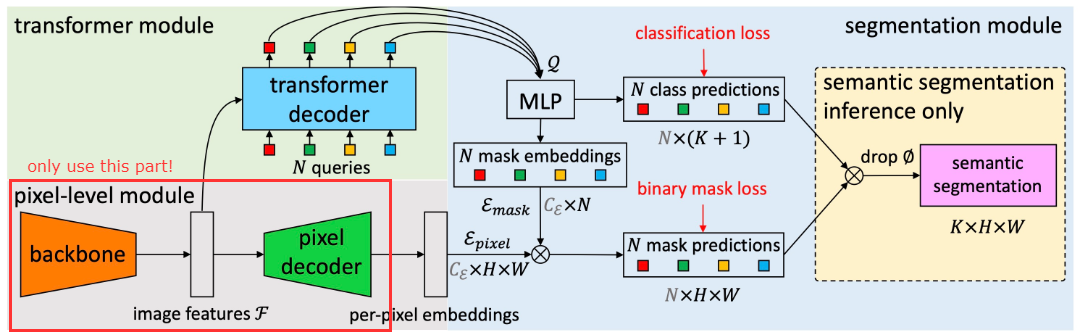

**Hint**: You can use `model.named_modules()` to observe modules inside the model.

In [ ]:
maskformer = MaskFormerForInstanceSegmentation.from_pretrained(model_name)
for name, module in maskformer.named_modules():
  print(name)

TODO 13: extract the pixel-level module from maskformer and also replace the last layer (mask prediction) with a new convolutional layer (outchannel=1, kernel_size=3, stride=1, padding=1).

In [ ]:
class SegmentModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        maskformer = MaskFormerForInstanceSegmentation.from_pretrained(model_name)
        # TODO 13.1: extract pixel-level module and create new mask projection
        pass

    def forward(self, pixel_values):
        # TODO 13.2: extract pixel-level module and create new mask projection
        # Note: Do not forget to interpolate the output to have the save size as pixel_values (the input)
        #       we will use the bilinear interpolation with align_corners set to False.
        pass

The number of parameters in the extracted pixel-level module should be around 31,239,099.

In [ ]:
from torchinfo import summary
model = SegmentModel(model_name)

pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

summary(model, input_size=[(32, 3, 32, 32)], dtypes=[torch.float])

## Insert LoRA into the MaskFormer model

The concept of LoRA is that we are going to estimate the gradient (adaptation matrix) with two smaller matrices ($A$ and $B$):
\begin{aligned}
\text{Adaptation Matrix} = B \times A
\end{aligned}
where $\text{Adaptation Matrix} \in \mathbb{R}^{m \times n}$, $A \in \mathbb{R}^{r \times n}$, and $B \in \mathbb{R}^{m \times r}$. We could make this approximation based on the assumption that $\text{Adaptation Matrix}$ has a rank of $r$. Therefore, the fine-tuned weight becomes
\begin{aligned}
W &= W_0 + \Delta W \\
&= W_0 + \frac{\alpha}{r} BA
\end{aligned}
where $W$ denotes the fine-tuned weight, $W_0$ represents pre-trained weight, $\Delta W$ is the gradient and $\alpha$ can be seen as a learning rate. $A$ is initialized using a common initialization, like Kaiming initialization, during the initialization process. On the other hand, $B$ is set to 0 such that the model's output remains the same after injecting LoRA, resulting in a stabilized training process.

To summarize, when injecting LoRA to a layer, we insert new parameters called matrix A and B and initialize them using the above description. Then, we modify the forward pass with `forward_hook` such that the output becomes
\begin{aligned}
h = W x  +  \frac{\alpha}{r} BA x
\end{aligned}
where $x$ and $h$ are the input and output, respectively. We recommend you read this [blog](https://web.stanford.edu/~nanbhas/blog/forward-hooks-pytorch/#forward-hooks-101) to learn more about `forward_hook`.

**LoRA on Linear Layer**

TODO 14: initialize A and B to ones (every entry in the matrix is one), such that we can verify your forward pass after attach hook. \
TODO 15: implement the forward hook such that new output $h$ is
$$h = W x  +  \frac{\alpha}{r} BA x$$

**LoRA on Convolutional Layer**

TODO 16: initialize A and B to ones (every entry in the matrix is one), such that we can verify your forward pass after attach hook. \
TODO 17: implement the forward hook such that new output $h$ is
$$h = W x  +  \frac{\alpha}{r} BA x$$

**Note**: When injecting LoRA into a convolutional layer with kernel size $k$, the shape of matrix $A$ and $B$ becomes $(r \times k, \text{in features} \times k)$ and $(\text{out features} \times k, r \times k)$, respectively. It comes from the fact that we can see the weight of the convolutional layer as the weight of $k \times k$ linear layers.

**Hint**: When you want to declare and initialize a parameter, you can use `torch.nn.Parameter` and `torch.nn.init`, respectively.

In [ ]:
import math
# Initialize LoRA and attach a hook.
def attach_lora(layer, r, lora_alpha, in_features, out_features):
    assert r > 0, "rank must greater than 0."
    # TODO 14: Declare A and B matrices and initialize A and B to ones.
    layer.lora_A = None
    layer.lora_B = None

    def hook(model, input, output):
        assert len(input) == 1, "The length of the input must be 1."
        # TODO 15: Compute adapatation matrix (BA) and modify the forward pass.
        pass

    return hook

def attach_conv_lora(layer, r, lora_alpha, in_features, out_features, kernel_size):
    assert r > 0, "rank must greater than 0."
    # TODO 16: initialize metrix A and B in LoRA
    layer.lora_A = None
    layer.lora_B = None

    def hook(model, input, output):
        assert len(input) == 1, "The length of the input must be 1."
        # TODO 17: Compute adapatation matrix (BA) and modify the forward pass.
        pass
    return hook

To test your `forward_hook`, we will check the difference of the output before and after injecting the LoRA when you initialize matrices A and B with ones.

In [ ]:
class DummyLinear(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(10, 20)

  def forward(self, x):
    return self.linear(x)

r, lora_alpha = 1, 4
input_ = torch.arange(10, dtype=torch.float32).unsqueeze(0)
dummy_linear = DummyLinear()
output_before = dummy_linear(input_)
for name, module in dummy_linear.named_modules():
  if isinstance(module, torch.nn.modules.Linear):
    out_features, in_features = module.weight.shape
    h = module.register_forward_hook(attach_lora(module, r, lora_alpha, in_features, out_features))
output_after = dummy_linear(input_)

if torch.all(torch.isclose(output_after - output_before, lora_alpha * input_.sum() * torch.ones_like(output_before))):
  print("Your forward hook seems to be correct.")
else:
  print("There is something wrong with your forward hook.")

### Analyze Low-rank Adaptation (TODO)
How many parameters in DummyLinear module before and after injecting LoRA?

Ans.

Check LoRA in convolutional layer

In [ ]:
class DummyConvolution(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Conv2d(10, 20, kernel_size=3, stride=3)

  def forward(self, x):
    return self.conv(x)

r, lora_alpha = 1, 4
input_ = torch.ones(1, 10, 9, 9) # torch.arange(10, dtype=torch.float32).unsqueeze(0)
dummy_conv = DummyConvolution()
output_before = dummy_conv(input_)
for name, module in dummy_conv.named_modules():
  if isinstance(module, torch.nn.modules.Conv2d):
      in_features, out_features, kernel_size, _ = module.weight.shape
      assert kernel_size == _
      h = module.register_forward_hook(attach_conv_lora(module, r, lora_alpha, in_features, out_features, kernel_size))
output_after = dummy_conv(input_)

if torch.all(torch.isclose(output_after - output_before, 1080 * torch.ones_like(output_before))):
  print("Your forward hook seems to be correct.")
else:
  print("There is something wrong with your forward hook.")

**Instruction**

TODO 18-19: Change the initialization of A and B where A is initialized with Kaiming Uniform (a = sqrt(5)), and B is set to 0.

In [ ]:
import math
# Initialize LoRA and attach a hook.
def attach_lora(layer, r, lora_alpha, in_features, out_features):
    assert r > 0, "rank must greater than 0."
    # TODO 18: initialize A with kaiming uniform with a = sqrt(5) and initialize B to 0.
    layer.lora_A = None
    layer.lora_B = None

    def hook(model, input, output):
        assert len(input) == 1, "The length of the input must be 1."
        # Copy from TODO 15
        pass

    return hook

def attach_conv_lora(layer, r, lora_alpha, in_features, out_features, kernel_size):
    assert r > 0, "rank must greater than 0."
    # TODO 19: initialize A with kaiming uniform with a = sqrt(5) and initialize B to 0
    layer.lora_A = None
    layer.lora_B = None

    def hook(model, input, output):
        assert len(input) == 1, "The length of the input must be 1."
        # COPY from TODO 17
        pass
    return hook

We only inject LoRA into the convolutional layer in the decoder block. \
TODO 20: inject lora into a decoder block

In [ ]:
r, lora_alpha = 1, 4
def attach_lora_to_maskformer(model, r, lora_alpha):
  hooks = []
  for name, module in model.named_modules():
      # TODO 20: inject lora into convolutional layers in the decoder block
      # Do not forget to append registered hook to hooks
      pass
  return hooks

hooks = attach_lora_to_maskformer(model, r, lora_alpha)

We freeze every layer except LoRA layer (A and B matrix), bias in the decoder, and the last layer (segment_prediction). \
TODO 21: freeze every layer except LoRA layer (A and B matrix), bias in the decoder, and the last layer (segment_prediction).

In [ ]:
for n, p in model.named_parameters():
    # TODO 21: freeze every layer except LoRA layer, bias in the decoder and the last layer.
    pass

The number of learnable parameters is around 28k.

In [ ]:
pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(pytorch_total_params)

## Training

In [ ]:
from tqdm import tqdm

# Save on the trainable parameters
def save_trainable_params(model, path):
  trainable_state_dict = {}
  for n, p in model.named_parameters():
    if p.requires_grad:
      trainable_state_dict[n] = p

  torch.save(trainable_state_dict, path)


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
criteria = nn.BCEWithLogitsLoss()
# Initialize Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# Set number of epochs and batch size
num_epochs = 10
training_losses = []
validation_losses = []
for epoch in range(num_epochs):
    print(f"Epoch {epoch} | Training")
    # Set model in training mode
    model.train()
    train_loss, val_loss = [], []
    # Training loop
    for idx, batch in enumerate(tqdm(train_dataloader)):
        # Reset the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(batch["pixel_values"].to(device))
        # Backward propagation
        loss = criteria(outputs.squeeze(1), batch["segmentation"].to(device))
        train_loss.append(loss.item())
        loss.backward()
        if idx % 100 == 0:
            print("  Training loss: ", round(sum(train_loss)/len(train_loss), 6))
        # Optimization
        optimizer.step()
        torch.cuda.empty_cache()
    # Average train epoch loss
    train_loss = sum(train_loss)/len(train_loss)
    # Set model in evaluation mode
    model.eval()
    start_idx = 0
    print(f"Epoch {epoch} | Validation")
    for idx, batch in enumerate(tqdm(val_dataloader)):
        with torch.no_grad():
            # Forward pass
            outputs = model(batch["pixel_values"].to(device))
            # Get validation loss
            loss = criteria(outputs.squeeze(1), batch["segmentation"].to(device))
            val_loss.append(loss.item())
            if idx % 50 == 0:
                print("  Validation loss: ", round(sum(val_loss)/len(val_loss), 6))
        torch.cuda.empty_cache()
    # Average validation epoch loss
    val_loss = sum(val_loss)/len(val_loss)

    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    # Print epoch losses
    print(f"Epoch {epoch} | train_loss: {train_loss} | validation_loss: {val_loss}")

save_trainable_params(model, "./lora_weight.ckpt")

Plot training and validation loss.

In [ ]:
plt.plot(range(num_epochs), training_losses, label="training loss")
plt.plot(range(num_epochs), validation_losses, label="validation loss")
plt.legend()
plt.show()

In [ ]:
test_loss = []
for idx, batch in enumerate(tqdm(test_dataloader)):
    with torch.no_grad():
        outputs = model(batch["pixel_values"].to(device))
        loss = criteria(outputs.squeeze(1), batch["segmentation"].to(device))
        test_loss.append(loss.item())
    torch.cuda.empty_cache()
# Average validation epoch loss
test_loss = sum(test_loss)/len(test_loss)
print("Test Loss:", test_loss)

## Inference

After fine-tuning the model, we need to load the model back for inference. First, we load the pre-trained weight. Next, we attach LoRA to the foundation model and then load the LoRA's weight.

In [ ]:
model = SegmentModel(model_name)
hooks = attach_lora_to_maskformer(model, r, lora_alpha)

model.load_state_dict(torch.load("./lora_weight.ckpt"), strict=False)
model.cuda()

test_loss = []
for idx, batch in enumerate(tqdm(test_dataloader)):
    with torch.no_grad():
        outputs = model(batch["pixel_values"].to(device))
        loss = criteria(outputs.squeeze(1), batch["segmentation"].to(device))
        test_loss.append(loss.item())
    torch.cuda.empty_cache()
# Average validation epoch loss
test_loss = sum(test_loss)/len(test_loss)
print("Test Loss:", test_loss)

In [ ]:
test_dataloader = DataLoader(
    test_dataset,
    batch_size=1,
    shuffle=False,
    collate_fn=collate_fn
)
num_images = 10
model.cuda()
for idx, batch in enumerate(test_dataloader):
    image = unnormalize_image(batch["pixel_values"][0])
    outputs = model(batch["pixel_values"].to(device))
    outputs = F.sigmoid(outputs).cpu().detach().numpy()

    mask = batch["segmentation"][0]

    fig, axs = plt.subplots(ncols=3, figsize=(20, 10))
    axs[0].imshow(np.array(rearrange(image, "c h w -> h w c")))
    axs[1].imshow(outputs[0].squeeze())
    axs[2].imshow(np.array(mask))
    axs[0].set_axis_off()
    axs[1].set_axis_off()
    axs[2].set_axis_off()
    plt.show()

    if idx >= num_images:
        break

# (Optional) Part 3: Low-rank Adaptation on Diffusion

In this section, we combine sections 1 and 2. Instead of controlling the diffusion with digits, we will regulate it with text by using CLIP, trained to align the text and image embedding in the same space.

To make it even more interesting, we fill color into the MNIST dataset and use the prompt to generate the desired images. In addition, we color only digits 0 to 4 while leaving digits 5-9 to their original color (white).

## Preprocessing

First, we create Dataset and declare six colors, including red, green, blue, purple, yellow and white. Then we define the corresponding prompt for each image.

In [ ]:
import random
from PIL import Image

COLOR = {
    "red": (1, 0, 0),
    "green": (0, 1, 0),
    "blue": (0, 0, 1),
    "purple": (1, 0, 1),
    "yellow": (1, 1, 0),
    "white": (1, 1, 1)
}

def fill_color(img, color):
    """ Filled color into the image.

    Args:
        img (PIL.Image): A pillow image to be filled.
        color (str): A color to be used.
    Returns:
        The modified image (PIL.Image)
    """
    r, g, b = COLOR[color]
    data = np.array(img)   # "data" is a height x width x 4 numpy array
    data[..., 0] *= r
    data[..., 1] *= g
    data[..., 2] *= b
    data = data.astype(np.uint8)
    img = Image.fromarray(data)
    return img

class MNISTCaptionDatset(Dataset):
    def __init__(self, tokenizer, color=False, *args, **kwargs):
        """ Initialize MNIST dataset with text label.

        Args:
            color (bool): If set to true, the digit is filled with random color. Default to False.
        """
        assert kwargs.get("transform") is None, "Do not support transform function."
        self.data = datasets.MNIST(*args, **kwargs)
        self.tokenizer = tokenizer
        self.color = color
        self.classes = list(map(lambda text_label: text_label.split()[-1], self.data.classes))
        # Default transform function
        self.transform = Compose([
            ToTensor(), Resize((32, 32)), normalize_to_neg_one_to_one
        ])

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img, label = self.data[idx]
        img = img.convert('RGB')
        color = ""
        if self.color and label in list(range(0, 5)):
            color = random.choice(list(COLOR.keys()))
            color = "" if color == "white" else color
            if color != "":
                img = fill_color(img, color)
        img = self.transform(img)

        text_label = " ".join([self.classes[label], color]).strip()
        input_ids = self.tokenizer(text_label, padding="max_length", truncation=True, max_length=self.tokenizer.model_max_length, return_tensors="pt").input_ids[0]
        return img, input_ids

In [ ]:
from transformers import CLIPTextModel, CLIPTokenizer

mnist_kwargs = {
    "root":"./data",
    # download=True,
}
tokenizer = CLIPTokenizer.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="tokenizer", revision=None)
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", revision=None)

train_data = MNISTCaptionDatset(tokenizer, color=True, train=True, **mnist_kwargs)
test_data = MNISTCaptionDatset(tokenizer, color=True, train=False, **mnist_kwargs)

train_dataloader = DataLoader(train_data, batch_size=128)
test_dataloader = DataLoader(test_data, batch_size=128)

In [ ]:
for i in range(10):
    image, label = train_data[i]
    text = tokenizer.decode(label, skip_special_tokens=True)
    plt.imshow(rearrange(unnormalize_to_zero_to_one(image), "c h w -> h w c"))
    plt.title("Prompt: " + text)
    plt.axis(False)
    plt.show()

## Load Model

After preprocessing the data, we load the diffusion model and then inject the LoRA.

In [ ]:
unet = Unet(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
)

model = Diffusion(
    unet,
    linear_scheduler,
    resolution=(32, 32),
)

checkpoint = torch.load("./last_weight.ckpt")
model.load_state_dict(checkpoint["model_state_dict"])

### Insert LoRA into diffusion model

Which modules should you inject the LoRA? (OT 1) \
Ans.

**Instruction**

OT 2: inject LoRA into diffusion model

In [ ]:
r = 8
hooks = []
for name, module in model.named_modules():
    # OT 2: inject LoRA
    pass

After inserting LoRA, we freeze the model and train only LoRA.

**Instruction**

OT 3: freeze model and train only matrics A and B, and bias.

In [ ]:
for n, p in model.named_parameters():
    # OT 3: freeze model and train only matrics A and B, and bias.
    pass

## Training

In [ ]:
class Trainer:
    def __init__(
        self,
        model,
        tokenizer,
        text_encoder,
        train_dataloader,
        val_dataloader,
        ckpt_path,
        resolution=None,
        lr=1e-4,
        device="cuda",
    ):
        self.model = model
        self.tokenizer = tokenizer
        self.text_encoder = text_encoder

        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.resolution = next(iter(train_dataloader))[0].shape[-2:] if resolution == None else resolution

        self.lr = lr
        self.configure_optimizers()

        self.ckpt_path = ckpt_path
        self.device = device
        self.epoch = 0
        self.mode = "train"

        self.to(device)

    def configure_optimizers(self):
        """Construct Optimizer"""
        self.optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)

    def _step(self, batch):
        """One step forward pass

        Args:
            batch (Tuple[torch.tensor]): A mini-batch data to be processed. The first index must contain images
                and the latter are the corresponded label. The shape of image is (B, C, H, W),
                while the shape of label is (B).

        Returns:
            loss (torch.tensor): A loss value to be used for updating the model.

        """
        x, context = batch
        # TODO 12: calculate the loss given batch
        # Pseudo code:
        #   1. acquire the context embedding through self.embedding
        #   2. expand dimension such that the shape of embedding is (batch_size, 1, dimension)
        #   3. calculate loss using self.model.p_losses
        context = self.text_encoder(context, return_dict=False)[0]
        losses = self.model.p_losses(x, context)
        return losses

    def optimizer_step(self, loss):
        """Update model based on the given loss.

        Args:
            loss (torch.tensor): A loss value to be differentiated (Note: must be able to compute a gradient.)

        """
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()

    def train_loop(self, epoch):
        """One epoch training loop.

        Args:
            epoch (int): A current epoch.

        Returns:
            train_loss (np.array): A list of loss in each batch.

        """
        self.train()
        with tqdm(self.train_dataloader, unit="batch", leave=False) as tbatch:
            train_loss = []
            for batch in tbatch:
                tbatch.set_description(f"Epoch {epoch+1}")
                batch = list(
                    map(lambda x: x.to(self.device), batch)
                )  # allocate data on the pre-defined device.
                loss = self._step(batch)  # forward pass and calculate loss
                self.optimizer_step(loss)  # backward pass / updating the parameters
                train_loss.append(loss.item())
                tbatch.set_postfix(loss=loss.item())
            train_loss = np.array(train_loss)
        return train_loss

    def val_loop(self, epoch):
        """One epoch validating loop.

        Args:
            epoch (int): A current epoch.

        Returns:
            train_loss (np.array): A list of loss in each batch.

        """
        self.eval()
        # with self.ema.average_parameters():  # Copy EMA weight to model and restore after exiting `with`
        with tqdm(self.val_dataloader, unit="batch", leave=False) as tbatch:
            val_loss = []
            for batch in tbatch:
                tbatch.set_description(f"Epoch {epoch+1}")
                batch = list(
                    map(lambda x: x.to(self.device), batch)
                )  # allocate data on the pre-defined device.
                loss = (
                    self._step(batch).detach().cpu()
                )  # forward pass and calculate loss
                val_loss.append(loss.item())
                tbatch.set_postfix(loss=loss.item())
            val_loss = np.array(val_loss)
        return val_loss

    def fit(self, epochs, num_val_sampler=2, ckpt_path=None, resume=False, sampling_round=10):
        """Train the model

        Args:
            epochs (int): A number of epochs to be trained.

        Returns:
            train_epoch (np.array): A list of training loss in each epoch.
            val_epoch (np.array): A list of validation loss in each epoch.

        """
        best_val_loss = None
        ckpt_path = self.ckpt_path if ckpt_path is None else ckpt_path
        last_path = os.path.join(ckpt_path, "last_weight.ckpt")
        print("Save:", last_path)
        self.to(self.device)

        train_loss_epoch = []
        val_loss_epoch = []

        epochs = range(self.epoch, self.epoch+epochs) if resume == True else range(epochs)
        for epoch in epochs:
            self.epoch = epoch

            train_loss = self.train_loop(epoch) # Training Model
            val_loss = self.val_loop(epoch) # Evaluating Model

            if (epoch+1)%sampling_round == 0 or epoch == 0:
                self.sampling_image(num_val_sampler) # Generating new images

            print(
                f"Epoch {epoch+1}: Train Loss {train_loss.mean().item()}, Val Loss {val_loss.mean().item()}"
            )
            train_loss_epoch.append(train_loss.mean().item())
            val_loss_epoch.append(val_loss.mean().item())

            torch.cuda.empty_cache() # Clear GPU cache

        self.save(last_path)
        train_loss_epoch = np.array(train_loss_epoch)
        val_loss_epoch = np.array(val_loss_epoch)
        return train_loss_epoch, val_loss_epoch

    def sampling_image(self, num_images):
        """Sampling new images

        The sampling images was exhibited in a column format, using matplotlib.

        Args:
            num_images (int): A number of images to be generated.

        """
        self.eval()
        fig, axs = plt.subplots(ncols=num_images)
        text_label = random.choices(["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"], k=num_images)
        text_label = list(map(lambda x: " ".join([x, random.choice(list(COLOR.keys()))]), text_label))
        input_ids = self.tokenizer(text_label, padding="max_length", truncation=True, max_length=self.tokenizer.model_max_length, return_tensors="pt").input_ids.to(self.device)
        context = self.text_encoder(input_ids, return_dict=False)[0]
        sampled_images = self.model.sample(batch_size = num_images, context=context)#
        for idx_sampler in range(num_images):
            axs[idx_sampler].imshow(rearrange(unnormalize_to_zero_to_one(sampled_images[idx_sampler]), "c h w -> h w c"), cmap="gray")
            axs[idx_sampler].set_axis_off()
            axs[idx_sampler].set_title(text_label[idx_sampler])
        plt.show()

    def save(self, path):
        """ Save trainer state """
        path = self.ckpt_path if path is None else path
        torch.save({
            "epoch": self.epoch,
            "model_state_dict": self.model.state_dict(),
            "optimizer_state_dict": self.optimizer.state_dict(),
            "text_encoder": self.text_encoder.state_dict(),
        }, path)

    def load(self, path):
        """ Load trainer state """
        checkpoint = torch.load(path)
        self.epoch = checkpoint["epoch"]
        self.model.load_state_dict(checkpoint["model_state_dict"])
        self.optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        self.text_encoder.load_state_dict(checkpoint["text_encoder"])

    def train(self):
        """ Set trainer to train mode """
        if self.mode != "train":
            self.model.train()
            self.mode = "train"

    def eval(self):
        """ Set trainer to evaluate mode """
        if self.mode != "eval":
            self.model.eval()
            self.mode = "eval"

    def to(self, device):
        """Set a computational device (eg. cpu or cuda).

        Args:
            device (str): A computational device to be computed on.

        """
        self.device = device
        self.model.to(device)
        self.text_encoder.to(device)

    def set_dataset(self, train_dataloader, val_dataloader, resolution=None):
        """Set a new dataset.

        Args:
            train_dataloader (torch.utils.data.DataLoader): A new training set.
            val_dataloader (torch.utils.data.DataLoader): A new validation set.
            resolution (Tuple[int], optional): A new resolution of the images in the given dataset. If None,
                it was set to the size of the first image. Default to None.

        """
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.resolution = next(iter(train_dataloader))[0].shape[-2:] if resolution == None else resolution

    def parameters(self):
        return [p for p in self.model.parameters() if p.requires_grad]


In [ ]:
text_encoder = CLIPTextModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="text_encoder", revision=None)

text_encoder.requires_grad_(False)

trainer_config = {
    "model": model,
    "tokenizer": tokenizer,
    "text_encoder": text_encoder,
    "train_dataloader": train_dataloader,
    "resolution": RESOLUTION,
    "val_dataloader": test_dataloader,
    "device": "cuda",
    "ckpt_path": "./weights/",
    "lr": 3e-4,
}

trainer = Trainer(**trainer_config)

In [ ]:
epoch = 10
train_losses, val_losses = trainer.fit(epoch)

In [ ]:
plt.plot(range(epoch), train_losses, label="training loss")
plt.plot(range(epoch), val_losses, label="validation loss")
plt.legend()
plt.show()

## Inference

Although the diffusion model is not trained to color the digit 5-9, it can generate the colored digit 5-9, achieving zero-shot generation capability.

In [ ]:
fig, axs = plt.subplots(ncols=10, nrows=10, figsize=(10, 10))
fig.tight_layout(pad=2)
text_label = ["zero", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine"]

generated_images = []
for iter in range(10):
    mod_text_label = list(map(lambda x: " ".join([x, random.choice(list(COLOR.keys()))]), text_label))
    input_ids = tokenizer(mod_text_label, padding="max_length", truncation=True, max_length=tokenizer.model_max_length, return_tensors="pt").input_ids.to("cuda")
    context = text_encoder(input_ids, return_dict=False)[0]
    sampled_images = trainer.model.sample(batch_size = 10, context=context)#
    generated_images.append(sampled_images)
    for idx_sampler in range(10):
        axs[iter][idx_sampler].imshow(rearrange(unnormalize_to_zero_to_one(sampled_images[idx_sampler]), "c h w -> h w c"), cmap="gray")
        axs[iter][idx_sampler].set_axis_off()
        axs[iter][idx_sampler].set_title(mod_text_label[idx_sampler])
plt.show()

### OT 4. Does our model have any other zero-shot generation capability?
Answer here

Hint: Is it possible to generate other colors?

# Conclusion

Congratulations! You have successfully built the DDPM and Low-Rank Adaptation. Fortunately, in the real world, there are pre-built libraries ready to be used without implementing both from scratch. For diffusion, we have [`diffusers`](https://huggingface.co/docs/diffusers/quicktour) library providing all the necessary modules for the diffusion pipeline, as well as LoRA, we can use [`peft`](https://huggingface.co/docs/peft/main/en/quicktour) library to inject LoRA into the model by declaring injected modules in the LoRAConfig. For more details, please visit the HuggingFace website.